# <center> Ultimate Data Science Challenge </center>

## Libraries & Modules

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns
import scipy.stats as stats

In [2]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import warnings # For handling error messages.


# 1. Exploratory Data Analysis

## 1.1 Load the data and resample to aggregate by every 15min

In [3]:
# Load json data into a dataframe
with open('logins.json') as f:
   json_data = json.load(f)
df_logins = pd.DataFrame(json_data)

# Convert time data into datetime format and set date as index
df_logins['login_time'] = df_logins['login_time'].astype('datetime64[ns]')
df_logins.set_index('login_time', inplace=True)

# Add extra count column to aggregate login counts for every 15min
df_logins['count'] = 1

# Check info to see if there are null entries
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   93142 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [4]:
# Resample data to aggregate by every 15min
df_logins = df_logins.resample('5T', label='right').sum()
df_logins.head()

,count
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:20:00,3
1970-01-01 20:25:00,1
1970-01-01 20:30:00,2
1970-01-01 20:35:00,3


# 1.2 Visualize the data

The data is currently aggregated by every 15min, therefore we can check the distribution over the course of 24hours for two different days.

Text(0, 0.5, 'Number of logins')

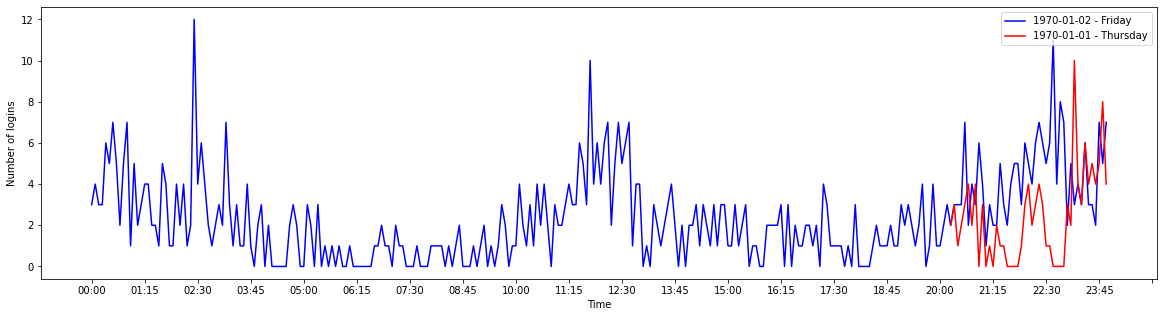

In [5]:
# Creating a library to map weekday number to a day name for plotting (legend) purposes
dayofweek = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}

# Example plot of 24hours of login counts, comparing the first two days of data
f,ax=plt.subplots(figsize=(20,5))
date1 = '1970-01-02'
date2 = '1970-01-01'
plt.plot(df_logins[date1].index.strftime('%H:%M'), df_logins[date1]['count'], color='blue')
plt.plot(df_logins[date2].index.strftime('%H:%M'), df_logins[date2]['count'], color='red')
plt.xlabel('Time')
plt.legend([date1+" - "+dayofweek[pd.to_datetime(date1).weekday()], 
            date2+" - "+dayofweek[pd.to_datetime(date2).weekday()]],
          loc='upper right')
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
plt.ylabel('Number of logins')

We notice that the first day is actually lacking data for a full 24 hour cycle, and by repeating the above plot, we realise that this is the case for the last day of data as well. Since we have enough other data points, we can get rid of the first and last days of data.

In [6]:
# Dopping first day and last day
df_logins = df_logins[~df_logins.index.normalize().isin(['1970-01-01', '1970-04-13'])]
df_logins.head()

,count
login_time,
1970-01-02 00:00:00,3
1970-01-02 00:05:00,4
1970-01-02 00:10:00,3
1970-01-02 00:15:00,3
1970-01-02 00:20:00,6


Now all our days have full 24 hour data! One more observation from the above plot is that the magnitude late hour logins differ between Thursday and Friday. Therefore, we can repeat the plot to see how the first two Thursdays compare, at least visually:

Text(0, 0.5, 'Number of logins')

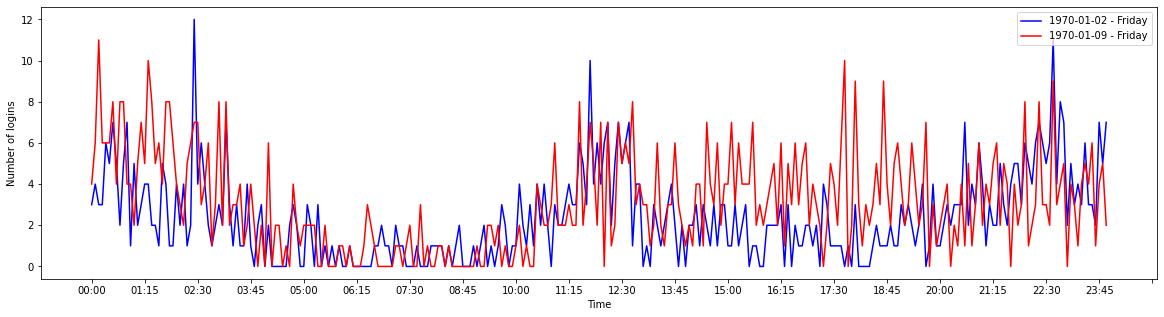

In [7]:
# Example plot of 24hours of login counts, comparing the first two Thursdays
f,ax=plt.subplots(figsize=(20,5))
date1 = '1970-01-02'
date2 = '1970-01-09'
plt.plot(df_logins[date1].index.strftime('%H:%M'), df_logins[date1]['count'], color='blue')
plt.plot(df_logins[date2].index.strftime('%H:%M'), df_logins[date2]['count'], color='red')
plt.xlabel('Time')
plt.legend([date1+" - "+dayofweek[pd.to_datetime(date1).weekday()], 
            date2+" - "+dayofweek[pd.to_datetime(date2).weekday()]],
          loc='upper right')
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
plt.ylabel('Number of logins')

As suspected, we see a much better alignment between these two days than in first plot!

# 1.2 The underlying patterns

We have already noted that the first two Thursdays visually look alike. Now we have to confirm this observation statistically and furthermore, we have to confirm that all common days of the week are also correlated with one another. We do this by using the first occuring date of the each day of the week as baseling, and running a Pearson correlation test against the respective subsequent dates for each day of the week.

Before assesing the correlation, we can first visualize and analyse our chosen baseline.

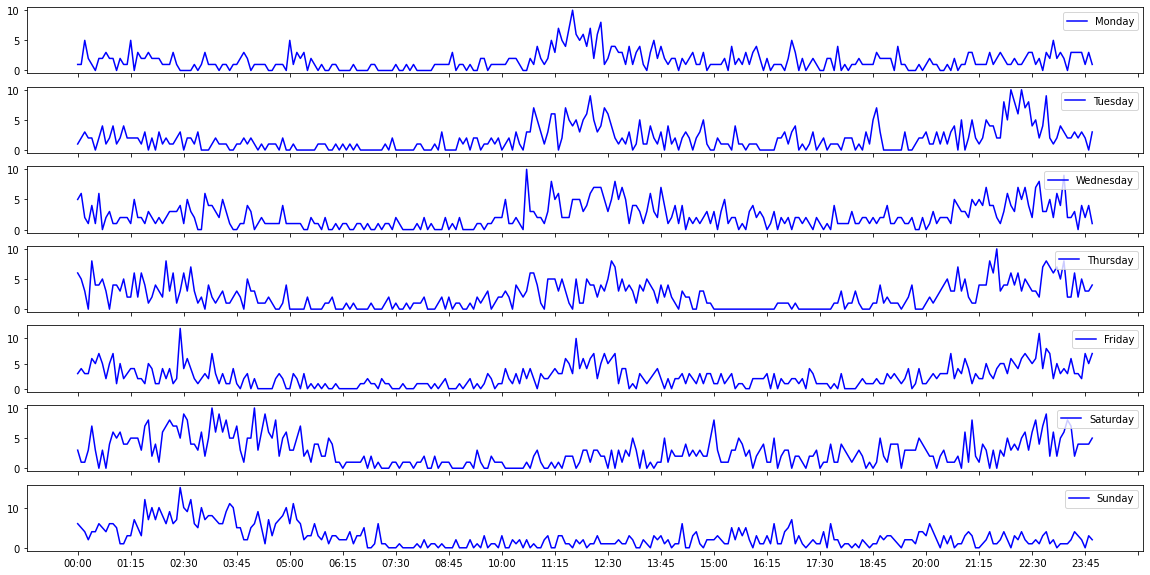

In [8]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, sharex=True, figsize=(20,10))
base_dates = ['1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08','1970-01-02', '1970-01-03', '1970-01-04']
ax1.plot(df_logins[base_dates[0]].index.strftime('%H:%M'), df_logins[base_dates[0]]['count'], color='blue', label="Monday")
ax1.legend(loc="upper right")
ax2.plot(df_logins[base_dates[0]].index.strftime('%H:%M'), df_logins[base_dates[1]]['count'], color='blue', label="Tuesday")
ax2.legend(loc="upper right")
ax3.plot(df_logins[base_dates[0]].index.strftime('%H:%M'), df_logins[base_dates[2]]['count'], color='blue', label="Wednesday")
ax3.legend(loc="upper right")
ax4.plot(df_logins[base_dates[0]].index.strftime('%H:%M'), df_logins[base_dates[3]]['count'], color='blue', label="Thursday")
ax4.legend(loc="upper right")
ax5.plot(df_logins[base_dates[0]].index.strftime('%H:%M'), df_logins[base_dates[4]]['count'], color='blue', label="Friday")
ax5.legend(loc="upper right")
ax6.plot(df_logins[base_dates[0]].index.strftime('%H:%M'), df_logins[base_dates[5]]['count'], color='blue', label="Saturday")
ax6.legend(loc="upper right")
ax7.plot(df_logins[base_dates[0]].index.strftime('%H:%M'), df_logins[base_dates[6]]['count'], color='blue', label="Sunday")
ax7.legend(loc="upper right")
ax7.xaxis.set_major_locator(plt.MaxNLocator(25))

Looking at our baseline plots, we observe that there are different user behaviors across the week. In general, starting from Monday, the number of logins peak at the middle of the day around lunch time. As we progress to later in the week, this user activity dampens and we start seeing more activity towards the later hours of the day or the early hours in the morning. For Saturday and Sunday, we specifically see the peaks in the early hours in the morning likely due to users going out.

Now that we have seen what the baseline looks like, we can see if the other dates available for each day of the week correlates to the above user activity.

In [9]:
# Creating a library to map dates available in the dataset to the days of the week
start_date = '1970-01-02'
end_date = '1970-04-12'
day_dates = {"Mon": [dates.strftime('%Y-%m-%d') for dates in pd.date_range(start=start_date, end=end_date, freq='W-MON')],
             "Tue": [dates.strftime('%Y-%m-%d') for dates in pd.date_range(start=start_date, end=end_date, freq='W-TUE')],
             "Wed": [dates.strftime('%Y-%m-%d') for dates in pd.date_range(start=start_date, end=end_date, freq='W-WED')],
             "Thu": [dates.strftime('%Y-%m-%d') for dates in pd.date_range(start=start_date, end=end_date, freq='W-THU')],
             "Fri": [dates.strftime('%Y-%m-%d') for dates in pd.date_range(start=start_date, end=end_date, freq='W-FRI')],
             "Sat": [dates.strftime('%Y-%m-%d') for dates in pd.date_range(start=start_date, end=end_date, freq='W-SAT')],
             "Sun": [dates.strftime('%Y-%m-%d') for dates in pd.date_range(start=start_date, end=end_date, freq='W-SUN')]}

In [10]:
# Go through each day of the week and see how the data for each day of the week 
# is correlated to the data of the first date for that day of the 
# The chosen test for correlation is the widely  used Pearson test
day_corr = {"Mon": [],"Tue": [],"Wed": [],"Thu": [],"Fri": [],"Sat": [],"Sun": []}
for day in day_dates:
    for date in day_dates[day][1:]:
        r, p = stats.pearsonr(df_logins[day_dates[day][0]]['count'], df_logins[date]['count'])
        day_corr[day].append(p)

df_corr = pd.DataFrame.from_dict(day_corr,orient='index').transpose()
df_corr

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,1.598896e-12,8.499851e-09,6.363685e-11,7.862901e-20,5.030221e-12,3.531368e-16,4.943590e-09
1,1.640370e-15,1.307126e-19,2.004304e-15,1.287444e-13,2.336200e-23,1.262274e-17,5.416375e-28
2,2.119167e-16,2.033533e-14,1.718837e-07,4.564071e-13,5.184361e-25,4.206412e-24,2.035128e-25
3,5.068376e-01,8.029816e-10,2.527457e-15,5.998579e-14,4.939522e-15,1.259823e-19,3.575561e-22
4,7.580571e-15,4.411516e-14,1.495824e-14,2.070750e-22,6.770115e-26,4.323697e-21,2.430093e-27
5,1.114893e-15,2.375477e-21,8.094797e-11,4.387266e-18,8.577147e-22,1.838230e-23,9.035039e-31
6,9.163499e-11,2.141641e-12,9.426484e-14,3.538288e-22,9.872127e-23,2.028391e-23,3.236935e-32
7,2.136420e-05,1.610809e-19,6.277476e-11,9.137862e-19,9.380938e-23,8.409458e-25,7.268406e-26
8,1.729080e-12,9.678301e-18,5.702002e-17,1.086348e-14,3.632096e-17,6.741082e-19,2.517003e-33
9,2.308880e-07,7.563749e-08,1.859571e-15,1.082181e-17,7.326894e-19,9.086618e-21,2.116288e-22


From the above table, our assumption that common days are correlated week-over-week is confirmed. There is only one data point which doesn't match the expected result: the correlation of the fourth occuring Monday against the first Monday is several orders of magnitude lower than the other Mondays. We can check out what is going visually. Since we have been repeating the same code for plotting, we can write a function for this:

In [11]:
def plot_dates(date1, date2):    
    f,ax=plt.subplots(figsize=(20,5))
    plt.plot(df_logins['1970-01-02'].index.strftime('%H:%M'), df_logins[date1]['count'], color='red')
    plt.plot(df_logins['1970-01-02'].index.strftime('%H:%M'), df_logins[date2]['count'], color='blue')
    plt.xlabel('Time')
    plt.legend([date1+" - "+dayofweek[pd.to_datetime(date1).weekday()], 
                date2+" - "+dayofweek[pd.to_datetime(date2).weekday()]])
    r, p = stats.pearsonr(df_logins[date1]['count'], df_logins[date2]['count'])
    plt.text(df_logins['1970-01-02'].index.strftime('%H:%M')[-30], 
             max(max(df_logins[date1]['count']), max(df_logins[date2]['count']))-3, 
             "Pearson Correlation: "+"{:.2E}".format(p), fontsize = 10)
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    plt.ylabel('Number of logins')

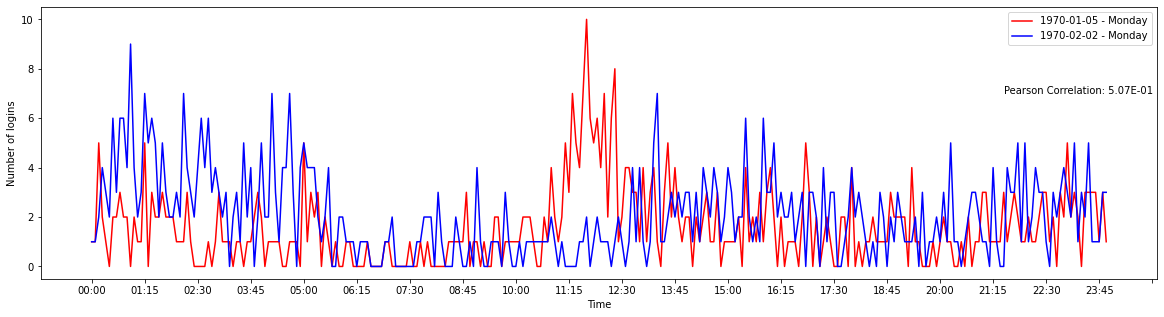

In [12]:
plot_dates('1970-01-05', '1970-02-02')

By plotting the Monday baseline on top of the poorly correlating Monday, we can observe the the baseline shows an expected user behavior for a weekday - highest activity during the day around lunch time. The poorly correlated Monday (1970-02-02) showcases a more weekend-like user activity, where the highest login counts happens in the early hours of the morning. To confirm the weekend-like activity, we can plot that Monday (1970-02-02) against the Sunday that occurs right before it.

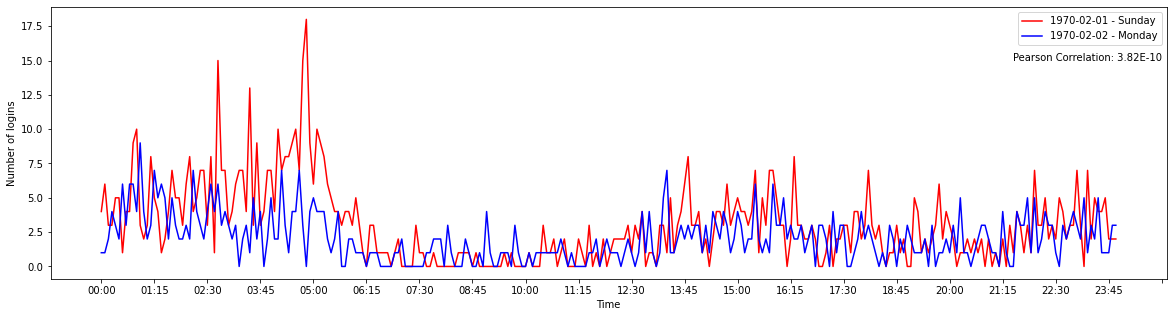

In [13]:
plot_dates('1970-02-01', '1970-02-02')

As expected, the Monday is very highly correlated with a Sunday activity - about 9 orders of magnitude more correlated than against the Monday baseline. One reason for this is that that Monday was potentially a public holiday, therefore users behaved the same way they would have on a Sunday.

# 2. Experiment and Metric Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

* What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
    * **I would use the percent of cross-city rides out of total rides completed by all drivers in the two cities over the course of at least 3 weeks. This will be a good metric because it offers an objective view of activity across the two cities regardless of the rise or drop in total number of rides. This metric is essentially a "probability" of a ride being cross-city ride.**
* Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    * how you will implement the experiment - 
    
    **I would collect data for 3 weeks before the change is implemented and 3 weeks after the change. I would allow at least a week of buffer for when the change is implemented before starting to collect the data to allow the drivers and users to learn about, react to and adapt to the change. Also, I would ideally ensure that the weeks over which I would collect the data are representative of normal business activity for the company. The data that would be collecting would be aggregated to number of cross-city rides over total number of rides.**
    
    * what statistical test(s) you will conduct to verify the significance of the observation - 
    
    **I would design an A/B test to compare the pre-change and post-change data collections. In order to assess whether we can reject the null hypothesis (that the change resulted in no difference between pre- and post-change), we can use a Z-test - assuming it is a large enough data pool.**
    
    * how you would interpret the results and provide recommendations to the city operations team along with any caveats. - 
    
    **For the alternative hypothesis, I would choose a one-tail test assuming that the change will result in the post-change dataset set to have a higher percentage of cross-city rides. Setting a 95% confidence level, we would only reject the null hypothesis if the p-value of the test is 5% or lower. In that case, we would claim that the new toll bridge reimbursement results in higher cross-city rides.**

# 3. Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

* Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
* Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
* Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

## 3.1 Data wrangling

In [14]:
# Load json data into a dataframe
with open('ultimate_data_challenge.json') as f:
   json_data = json.load(f)
df_raw = pd.DataFrame(json_data)

# Quickly check first 5 rows
df_raw.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
# Check the statistics of the quantitative columns
df_raw.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [16]:
# Check data types and non-null counts of all columns
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
# Convert the date columns to datetime for easier manipulations
df_raw['signup_date']= pd.to_datetime(df_raw['signup_date'])
df_raw['last_trip_date']= pd.to_datetime(df_raw['last_trip_date'])
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [32]:
# create a column to store the boolean value of whether a user is active after 6 months
df_raw["active_6months"] = df_raw.apply(lambda row: 1 if((row.last_trip_date.month - row.signup_date.month)>=6) 
                                    else 0, axis=1)

## 3.2 EDA

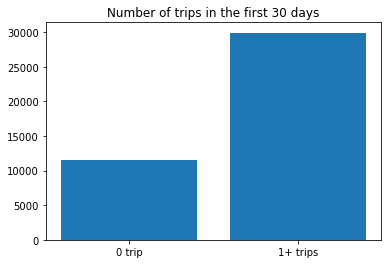

In [33]:
# histogram of trips_in_first_30_days
plt.bar(["0 trip", "1+ trips"], [df_raw.trips_in_first_30_days[df_raw.trips_in_first_30_days == 0].count(),
                                  df_raw.trips_in_first_30_days[df_raw.trips_in_first_30_days > 0].count()])
plt.title("Number of trips in the first 30 days");


In [34]:
# trips_in_first_30_days does not contain any null entries
# we can calculate portion of retained users
retain_pct = "{0:.2%}".format(df_raw.trips_in_first_30_days[df_raw.trips_in_first_30_days > 0].count() / 
df_raw.trips_in_first_30_days.count() )
print("Portion of users that were retained: ", retain_pct)

Portion of users that were retained:  72.19%


In [35]:
# drop null entries - we still have 85% of the original dataset for the training/modeling
df_raw.dropna(inplace=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  41445 non-null  int64         
 1   signup_date             41445 non-null  datetime64[ns]
 2   avg_rating_of_driver    41445 non-null  float64       
 3   avg_surge               41445 non-null  float64       
 4   last_trip_date          41445 non-null  datetime64[ns]
 5   surge_pct               41445 non-null  float64       
 6   ultimate_black_user     41445 non-null  int64         
 7   weekday_pct             41445 non-null  float64       
 8   avg_dist                41445 non-null  float64       
 9   avg_rating_by_driver    41445 non-null  float64       
 10  active_6months          41445 non-null  int64         
 11  iPhone                  41445 non-null  uint8         
 12  city_Astapor            41445 non-null  uint8 

In [36]:
# Conduct one hot encoding for the categorical field -  "phone" and "city"
df_raw = pd.concat([df_raw, pd.get_dummies(df_raw.phone)], axis=1)
df_raw = pd.concat([df_raw, pd.get_dummies(df_raw.city, prefix="city")], axis=1)
df_raw.drop(["phone", "Android", "city"], axis=1, inplace=True)

# Convert the Boolean field "ultimate_black_user" to integer
df_raw.ultimate_black_user = df_raw.ultimate_black_user.astype(int)

df_raw.head()

AttributeError: 'DataFrame' object has no attribute 'phone'

In [39]:
print("There are {} active and {} inactive users after 6 months.".format(
      df_raw[df_raw.active_6months==1].count()[0], df_raw[df_raw.active_6months==0].count()[0]))

There are 529 active and 40916 inactive users after 6 months.


Because of the imbalance in the number of active and inactive users, we have to upscale the minority to ensure that our training and modeling is not biased.

In [40]:
# Separate majority and minority classes
df_raw_maj = df_raw[df_raw.active_6months==0]
df_raw_min = df_raw[df_raw.active_6months==1]
 
# Upsample minority class
df_raw_min_upsampled = resample(df_raw_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=40916,    # to match majority class
                                 random_state=5) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_raw_maj, df_raw_min_upsampled])
 
# Display new class counts
print(df_upsampled.active_6months.value_counts())

# setting the target and exploratory variables
y = df_upsampled["active_6months"].values
X = df_upsampled.drop(["signup_date", "last_trip_date","active_6months"], axis=1).values

1    40916
0    40916
Name: active_6months, dtype: int64


In [60]:
df_upsampled.drop(["signup_date", "last_trip_date","active_6months"], axis=1).columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'iPhone', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell'],
      dtype='object')

In [42]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)

# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,random_state=5)

# Train model
rf_model = RandomForestClassifier()
rf_model.fit(Xtrain, ytrain)
 
# Predict on training set
rf_pred = rf_model.predict(Xtest)
 
# Is our model still predicting just one class?
print( np.unique( rf_pred ) )

# How's our accuracy?
print("Modeling accuracy: {:.5}".format(accuracy_score(ytest, rf_pred)) )
 
# What about AUROC?
rf_prob = rf_model.predict_proba(Xtest)
rf_prob = [p[1] for p in rf_prob]
print("AUC score: {:.5}".format(roc_auc_score(ytest, rf_prob)))
# 0.999078798186

[0 1]
Modeling accuracy: 0.99951
AUC score: 0.99995


The model is performing almost perfectly!

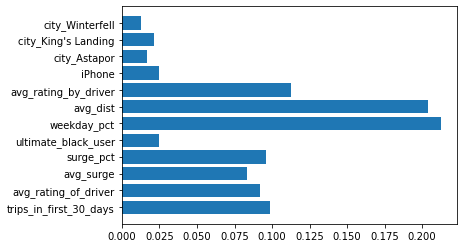

In [43]:
# Let's take a look at the most important features were in the model
_ = plt.barh(df_upsampled.drop(["signup_date", "last_trip_date","active_6months"], axis=1).columns, 
         rf_model.feature_importances_)

Now that we know that `weekday_pct` and `avg_dist` features are the most important features, we can take a look the distribution of these features to understand how users who are most active are behaving.

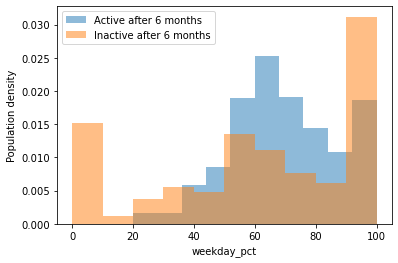

In [46]:
# Histogram for weekday_pct of active and inactive users 
plt.hist(df_raw[df_raw["active_6months"]==1]["weekday_pct"].values, alpha=0.5, label='Active after 6 months', density=True)
plt.hist(df_raw[df_raw["active_6months"]==0]["weekday_pct"].values, alpha=0.5, label='Inactive after 6 months', density=True)
plt.legend(loc='upper left')
plt.xlabel('weekday_pct')
plt.ylabel('Population density')
plt.show()

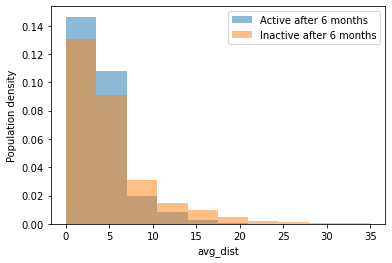

In [56]:
# Histogram for avg_rating_by_driver of active and inactive users 
plt.hist(df_raw[df_raw["active_6months"]==1]["avg_dist"].values, 
         alpha=0.5, label='Active after 6 months',range=[0, 35], density=True)
plt.hist(df_raw[df_raw["active_6months"]==0]["avg_dist"].values, 
         alpha=0.5, label='Inactive after 6 months',range=[0, 35], density=True)
plt.xlabel('avg_dist')
plt.ylabel('Population density')
plt.legend(loc='upper right')
plt.show()

## Conclusion

From the current database, and the definition of a retained user to be a user that took at least one trip in the first 30 days of subscription, we found the following:
* Portion of users that were retained: **72.19%**

In order to predict whether a user is gonna remain active after 6 months, we build a random forest model which uses the following features as input:

* `trips_in_first_30_days` 
* `avg_rating_of_driver`
* `avg_surge`
* `surge_pct` 
* `ultimate_black_user`
* `weekday_pct`
* `avg_dist`
* `avg_rating_by_driver`
* `iPhone`
* `city_Astapor`
* `city_King's Landing`
* `city_Winterfell` (the 3 cities were one-hot encoded)

The model performs excellently well on the test data which it had never seen and gives the following metrics:
* Modeling accuracy: **0.99951**
* AUC score: **0.99995**

In taking a look at the feature importance for the prediction, we find that these two features were the key drivers, in this order, to predict whether a user remains active after 6 months:
* `weekday_pct`
* `avg_dist`

Further looking at the histogram of values for these features for active and inactive users, we find that **active users were more likely to have taken short distances, and use the service 50-80% of the time during the weekday**. This user behavior makes sense because users willing to use the service for shorter displays that this service usage is part of their habits. Similarly, having the 50-80% of service usage during the week shows a rather even distribution of service across the week and the weekend, slightly higher for the week likely because there are more days in the week. So, once again, this user behavior shows that they have adopted this service as part of their daily habit.

In terms of recommendations, there are two possible avenues depending on the business needs:

1. Increase retention rate: The company should focus on users who are taking longer rides, and offer them incentives to use the service for shorter rides. The company should also consider giving incentives to weekend users to encourage to use the service the weekdays and vice versa.
2. Increase revenue from already retained users: The company can give incentives to retained users to take longer rides.